In [58]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [59]:
# Load the data
data = pd.read_csv('Organized_Data.csv', parse_dates=['Datetime'])
data.set_index('Datetime', inplace=True)

In [60]:
data = data[180:]
data = data.dropna().reset_index()
data.set_index('Datetime', inplace=True)

In [61]:
# Extract features and labels
X = data.drop(columns=['nb_persons_SH'])
y = data['nb_persons_SH']

In [62]:
# Normalize the features
# Min-Max Normalization
X_z_score = (X - X.mean()) / X.std()
X_min_max = (X - X.min()) / (X.max() - X.min())
X_folowup = X_z_score
print(X_min_max)

                 BT12.09ppm  Gradient BT12.09ppm  BT12.09°C  BT12.09%RH  \
Datetime                                                                  
02.02.2024 05:4    0.037746             0.541895   0.333333    0.048780   
02.02.2024 06:0    0.037746             0.541895   0.333333    0.048780   
02.02.2024 06:1    0.037746             0.570646   0.333333    0.048780   
02.02.2024 06:3    0.057080             0.570372   0.333333    0.105691   
02.02.2024 06:4    0.076229             0.570372   0.333333    0.105691   
...                     ...                  ...        ...         ...   
29.02.2024 22:4    0.076229             0.541895   0.333333    0.593496   
29.02.2024 23:0    0.076229             0.541895   0.333333    0.593496   
29.02.2024 23:1    0.076229             0.541895   0.333333    0.593496   
29.02.2024 23:3    0.076229             0.541895   0.333333    0.593496   
29.02.2024 23:4    0.076229             0.541895   0.333333    0.593496   

                 BT12.10

In [63]:
# Convert the dataframe to a NumPy array
array = X_folowup.values
# Reshape X_seq to (number of samples, sequence length, 1) for Conv1D
X_res = array.reshape((array.shape[0], array.shape[1], 1))

In [64]:
split_index = int(len(X) * 0.8)
X_train, X_valid = X_res[:split_index], X_res[split_index:]
y_train, y_valid = y[:split_index], y[split_index:]

In [66]:
# Build the 1D CNN model for regression
# model = Sequential([
#     Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
#     Flatten(),
#     Dense(50, activation='relu'),
#     Dense(1)  # Output layer for regression
# ])

#77%
# model = Sequential([
#     Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
#     MaxPooling1D(pool_size=2),
#     # Dropout(0.2),
#     Conv1D(filters=128, kernel_size=2, activation='relu'),
#     MaxPooling1D(pool_size=2),
#     # Dropout(0.2),
#     Flatten(),
#     Dense(100, activation='relu'),
#     # Dropout(0.2),
#     Dense(50, activation='relu'),
#     # Dropout(0.2),
#     Dense(1)  # Output layer for regression
# ])

model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    # Dropout(0.2),
    Conv1D(filters=128, kernel_size=2, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    # Dropout(0.2),
    Conv1D(filters=256, kernel_size=2, activation='relu'),
    BatchNormalization(),
    # MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    # Dropout(0.2),
    Dense(32, activation='relu'),
    # Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 11, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 11, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 4, 128)         │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 1, 256)         │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 1, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,857 (757.25 KB)

 Trainable params: 192,961 (753.75 KB)

 Non-trainable params: 896 (3.50 KB)

In [68]:

# Train the model
model.fit(X_train, y_train, epochs=2000, validation_data=(X_valid, y_valid), batch_size=32)


Epoch 1/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0590 - val_loss: 2.8720
Epoch 2/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0634 - val_loss: 2.7475
Epoch 3/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0568 - val_loss: 2.9321
Epoch 4/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0722 - val_loss: 2.7984
Epoch 5/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0592 - val_loss: 2.8515
Epoch 6/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0514 - val_loss: 2.9024
Epoch 7/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0549 - val_loss: 2.6878
Epoch 8/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0464 - val_loss: 2.4507
Epoch 9/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0430 - val_loss: 2.7286
Epoch 10/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0530 - val_loss: 2.5494
Epoch 11/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0559 - val_loss: 2.5273
Epoch 12/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

In [80]:
# Evaluate the model
loss = model.evaluate(X_valid, y_valid)
print(f'Test Loss: {loss}')

# Predict and compare with actual values
predictions = model.predict(X_valid)

# Example: Comparing the first 10 predictions with actual values
for i in range(10):
    print(f'Predicted: {predictions[i][0]}, Actual: {y_valid[i]}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7294     
Test Loss: 2.8198835849761963
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Predicted: 0.009385168552398682, Actual: 0.0
Predicted: 0.00935208797454834, Actual: 0.0
Predicted: 0.009009063243865967, Actual: 0.0
Predicted: 0.009322047233581543, Actual: 0.0
Predicted: 0.009366482496261597, Actual: 0.0
Predicted: 0.009274512529373169, Actual: 0.0
Predicted: 0.009314417839050293, Actual: 0.0
Predicted: 0.009314417839050293, Actual: 0.0
Predicted: 0.009134143590927124, Actual: 0.0
Predicted: 0.009063303470611572, Actual: 0.0


C:\Users\Charles\AppData\Local\Temp\ipykernel_23260\3906225907.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Predicted: {predictions[i][0]}, Actual: {y_valid[i]}')


In [81]:
# Calculate additional metrics
mae = mean_absolute_error(y_valid, predictions)
mse = mean_squared_error(y_valid, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

Mean Absolute Error (MAE): 0.7063750267377373
Mean Squared Error (MSE): 2.8198834051387274
Root Mean Squared Error (RMSE): 1.6792508464010751
R-squared (R2): 0.700909678807133


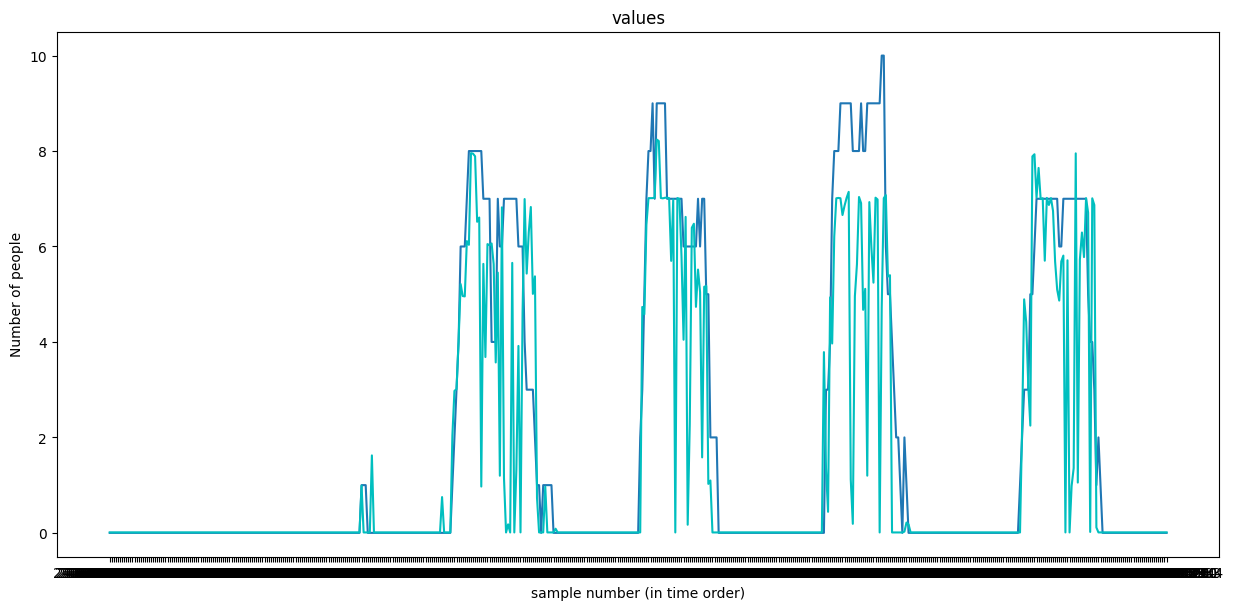

In [82]:
import matplotlib.pyplot as plt

#plot 1:
plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.plot(y_valid)
plt.plot(predictions,color='c')
plt.title('values')
plt.xlabel('sample number (in time order)')
plt.ylabel('Number of people')
"real values"
"predicted values"
plt.show()

In [83]:
def regression_accuracy(y_true, y_pred, margin):
    correct = np.sum(np.abs(y_true - y_pred) <= margin)
    total = len(y_true)
    accuracy = correct / total
    return accuracy * 100  # Return as percentage

# Example usage with a margin of 1
margin = 1.0
accuracy = regression_accuracy(y_valid, predictions[:][0], margin)
print(f'Regression Accuracy within ±{margin}: {accuracy:.2f}%')

Regression Accuracy within ±1.0: 70.37%


In [84]:
predictions_2 = model.predict(X_res)

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


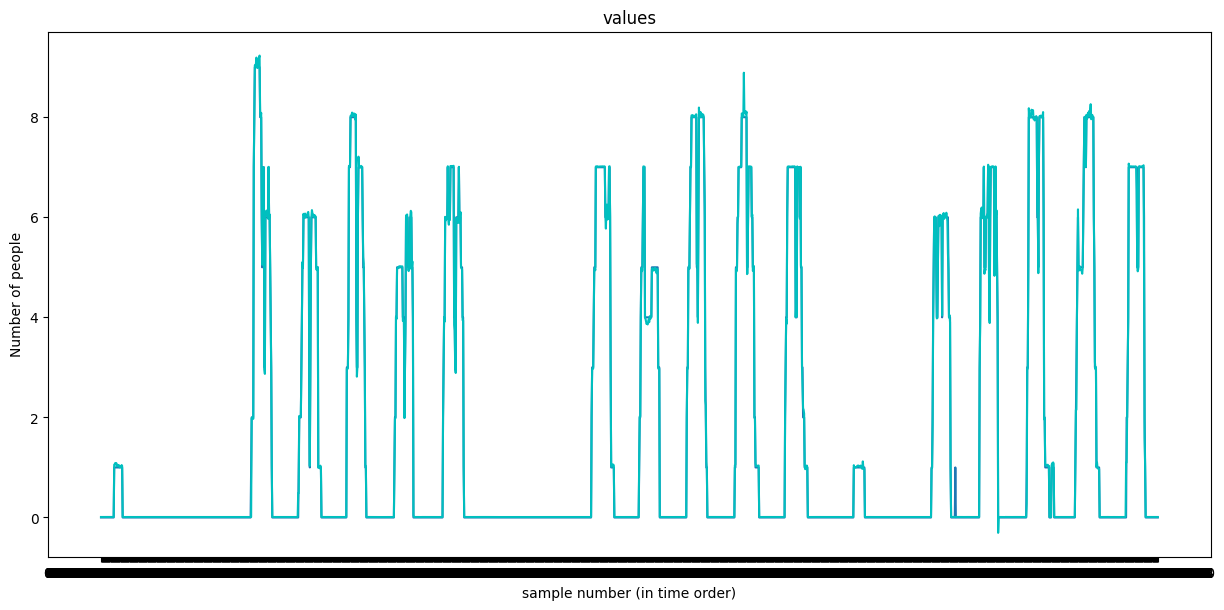

In [85]:
#plot 2:
plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.plot(y[:2000])
plt.plot(predictions_2[:2000],color='c')
plt.title('values')
plt.xlabel('sample number (in time order)')
plt.ylabel('Number of people')
"real values"
"predicted values"
plt.show()

In [86]:
margin = 1.0
accuracy_2 = regression_accuracy(y[:2000], predictions_2[:2000][0], margin)
print(f'Regression Accuracy within ±{margin}: {accuracy_2:.2f}%')

Regression Accuracy within ±1.0: 72.75%


In [87]:
def map_values_to_integers(lst):
    return [0 if x < 0 else int(x) for x in lst]

In [88]:
pred_map = map_values_to_integers(predictions_2[:])

C:\Users\Charles\AppData\Local\Temp\ipykernel_23260\1838952175.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [0 if x < 0 else int(x) for x in lst]


In [100]:
margin = 1
accuracy_2 = regression_accuracy(y, pred_map, margin)
print(f'Regression Accuracy within ±{margin}: {accuracy_2:.2f}%')

Regression Accuracy within ±1: 96.21%


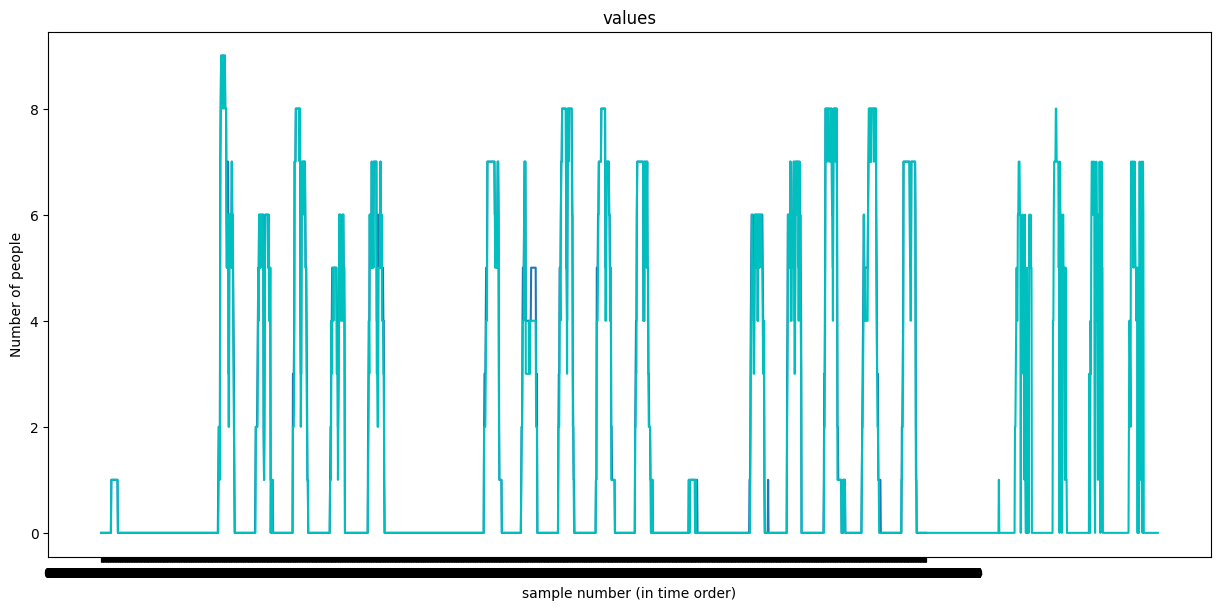

In [90]:
#plot 3:
plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.plot(y[:2000])
plt.plot(pred_map,color='c')
plt.title('values')
plt.xlabel('sample number (in time order)')
plt.ylabel('Number of people')
"real values"
"predicted values"
plt.show()

In [91]:
pred_map_inco = map_values_to_integers(predictions[:])
margin = 1.0
accuracy = regression_accuracy(y_valid, pred_map_inco, margin)
print(f'Regression Accuracy within ±{margin}: {accuracy:.2f}%')

Regression Accuracy within ±1.0: 81.29%


C:\Users\Charles\AppData\Local\Temp\ipykernel_23260\1838952175.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [0 if x < 0 else int(x) for x in lst]


In [77]:
# Calculate additional metrics
mae = mean_absolute_error(y_valid, pred_map_inco)
mse = mean_squared_error(y_valid, pred_map_inco)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, pred_map_inco)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

Mean Absolute Error (MAE): 0.7524366471734892
Mean Squared Error (MSE): 3.115009746588694
Root Mean Squared Error (RMSE): 1.7649390206431197
R-squared (R2): 0.6696071674707098


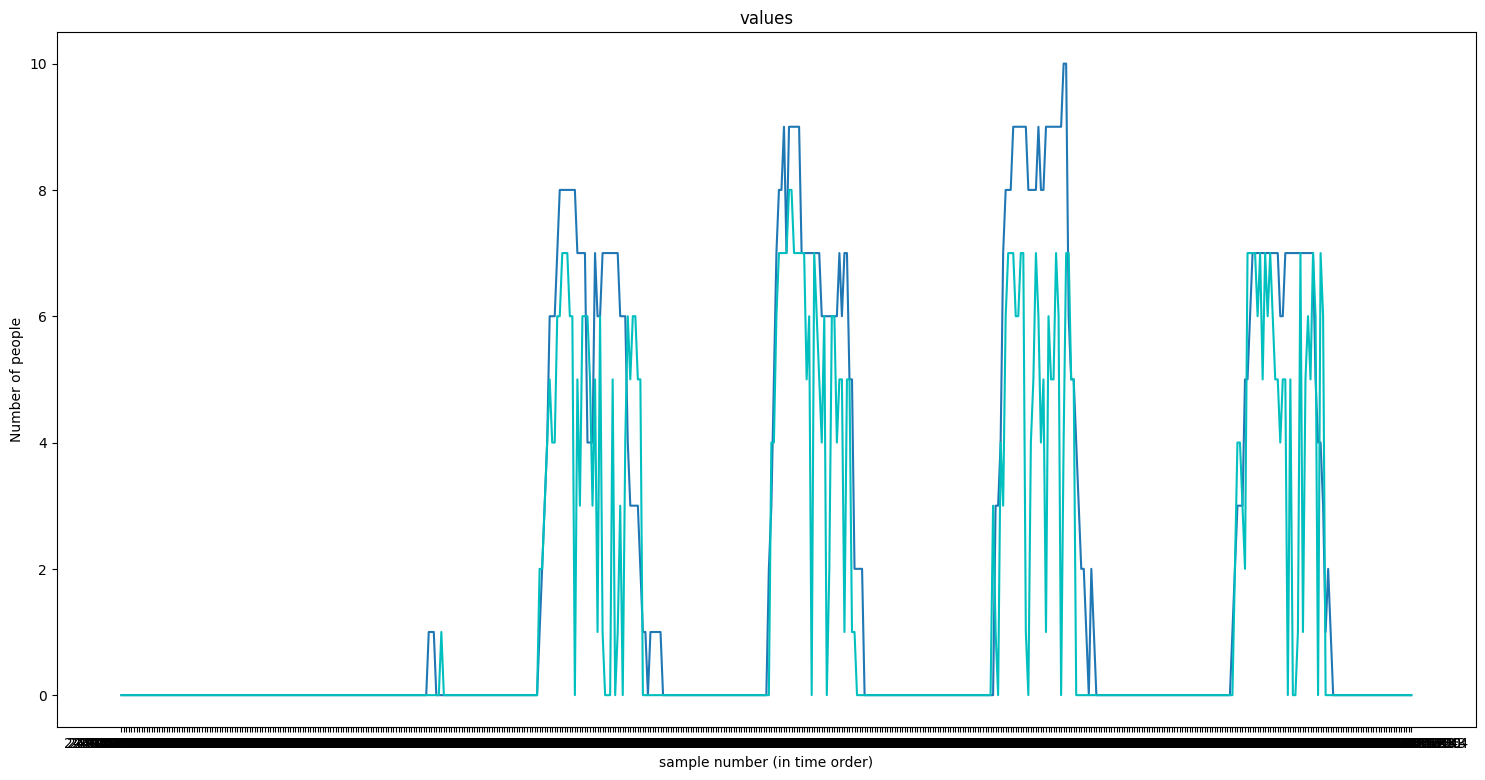

In [102]:
#plot 1:
plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.plot(y_valid)
plt.plot(pred_map_inco,color='c')
plt.title('values')
plt.xlabel('sample number (in time order)')
plt.ylabel('Number of people')
"real values"
"predicted values"
plt.tight_layout()
plt.show()

|Metrics|Mapped values|Raw values|
|---|---|---|
|Mean Absolute Error (MAE)| 0.8032128514056225|0.7160861778660232|
|Mean Squared Error (MSE)| 3.144578313253012|2.6598774615838456|
|Root Mean Squared Error (RMSE)| 1.7732958899329272| 1.6309130760355826|
|R-squared (R2)| 0.6724901887909691| 0.7229720876687895|

In [79]:
# Save the entire model to a keras file
model.save('1DCNN_reg_model_1.keras')

# Test with context

test avec les données séparées :

In [103]:
sequence_length = 10

# Calculate number of sequences we can create
num_sequences_train = X_train.shape[0] // sequence_length
num_sequences_valid = X_valid.shape[0] // sequence_length

# Truncate data to fit the sequences
X_train_truncated = X_train[:num_sequences_train * sequence_length]
X_valid_truncated = X_valid[:num_sequences_valid * sequence_length]
y_train_truncated = y_train[:num_sequences_train * sequence_length]
y_valid_truncated = y_valid[:num_sequences_valid * sequence_length]

# Reshape the data
X_train_reshaped = X_train_truncated.reshape((num_sequences_train, sequence_length, X_train.shape[1]))
X_valid_reshaped = X_valid_truncated.reshape((num_sequences_valid, sequence_length, X_valid.shape[1]))

# Convert y_train_truncated and y_valid_truncated to NumPy arrays and reshape
y_train_reshaped = np.array(y_train_truncated).reshape((num_sequences_train, sequence_length))
y_valid_reshaped = np.array(y_valid_truncated).reshape((num_sequences_valid, sequence_length))




In [104]:
# Define the model
model2 = Sequential([
    Input(shape=(sequence_length, X_train.shape[1])),
    Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=2, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=2, activation='relu', padding='same'),
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

model2.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)              │ (None, 10, 64)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 5, 128)         │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 2, 256)         │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 2, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,801 (1018.75 KB)

 Trainable params: 259,905 (1015.25 KB)

 Non-trainable params: 896 (3.50 KB)

In [106]:
# Train the model
model2.fit(X_train_reshaped, y_train_reshaped[:, 0], 
          epochs=500, validation_data=(X_valid_reshaped, y_valid_reshaped[:, 0]), batch_size=32)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 14.8666 - val_loss: 13.4879
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.3610 - val_loss: 13.2796
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.4441 - val_loss: 13.1924
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.6812 - val_loss: 13.0956
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.7943 - val_loss: 13.0009
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.6281 - val_loss: 12.8930
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.0264 - val_loss: 12.7371
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.5137 - val_loss: 12.5206
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3311 - val_loss: 12.2510
Epoch 10/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8319 - val_loss: 11.8965
Epoch 11/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9924 - val_loss: 11.4444
Epoch 12/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4879 - val

In [117]:
# Evaluate the model
loss = model2.evaluate(X_valid_reshaped, y_valid_reshaped[:, 0])
print(f'Test Loss (mae): {loss}')

# Predict and compare with actual values
predictions2 = model2.predict( X_valid_reshaped)

mse = mean_squared_error( y_valid_reshaped[:, 0], predictions2)
rmse = np.sqrt(mse)
r2 = r2_score( y_valid_reshaped[:, 0], predictions2)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5790 
Test Loss (mae): 3.415412187576294
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error (MSE): 3.41541188538169
Root Mean Squared Error (RMSE): 1.8480833004444606
R-squared (R2): 0.6324581583004645


In [133]:
# Save the entire model to a keras file
model2.save('1DCNN_reg_seq_no_floating_windows.keras')

## test avec les séquences qui s'entrecoupe :

In [118]:
# Define sequence length
sequence_length = 10

# Function to create overlapping sequences
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

# Create sequences
X_train_sequences = create_sequences(X_train, sequence_length)
X_valid_sequences = create_sequences(X_valid, sequence_length)

# Create corresponding target values (using the last value in each sequence)
y_train_sequences = y_train[sequence_length - 1:]
y_valid_sequences = y_valid[sequence_length - 1:]

In [119]:
# Define the model
model3 = Sequential([
    Input(shape=(sequence_length, X_train.shape[1])),
    Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=2, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=2, activation='relu', padding='same'),
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

model3.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error')
model3.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 10, 64)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 5, 128)         │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 2, 256)         │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 2, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,801 (1018.75 KB)

 Trainable params: 259,905 (1015.25 KB)

 Non-trainable params: 896 (3.50 KB)

In [111]:
# Train the model
model3.fit(X_train_sequences, y_train_sequences, 
          epochs=2000, validation_data=(X_valid_sequences, y_valid_sequences), batch_size=32)

Epoch 1/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 10.8338 - val_loss: 13.1459
Epoch 2/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5044 - val_loss: 12.5343
Epoch 3/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7127 - val_loss: 11.2480
Epoch 4/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4031 - val_loss: 9.3325
Epoch 5/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1648 - val_loss: 7.3302
Epoch 6/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5894 - val_loss: 5.7086
Epoch 7/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4416 - val_loss: 4.5948
Epoch 8/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9102 - val_loss: 3.9446
Epoch 9/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3486 - val_loss: 3.5786
Epoch 10/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4765 - val_loss: 3.3854
Epoch 11/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9768 - val_loss: 3.2314
Epoch 12/2000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

In [123]:
# Evaluate the model
loss = model3.evaluate(X_valid_sequences, y_valid_sequences)
print(f'Test Loss: {loss}')

# Predict and compare with actual values
predictions3 = model3.predict(X_valid_sequences)

mse = mean_squared_error(y_valid_sequences, predictions3)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid_sequences, predictions3)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7790 
Test Loss: 13.10152816772461
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Squared Error (MSE): 13.101528439830028
Root Mean Squared Error (RMSE): 3.6196033539367307
R-squared (R2): -0.3745201662525608


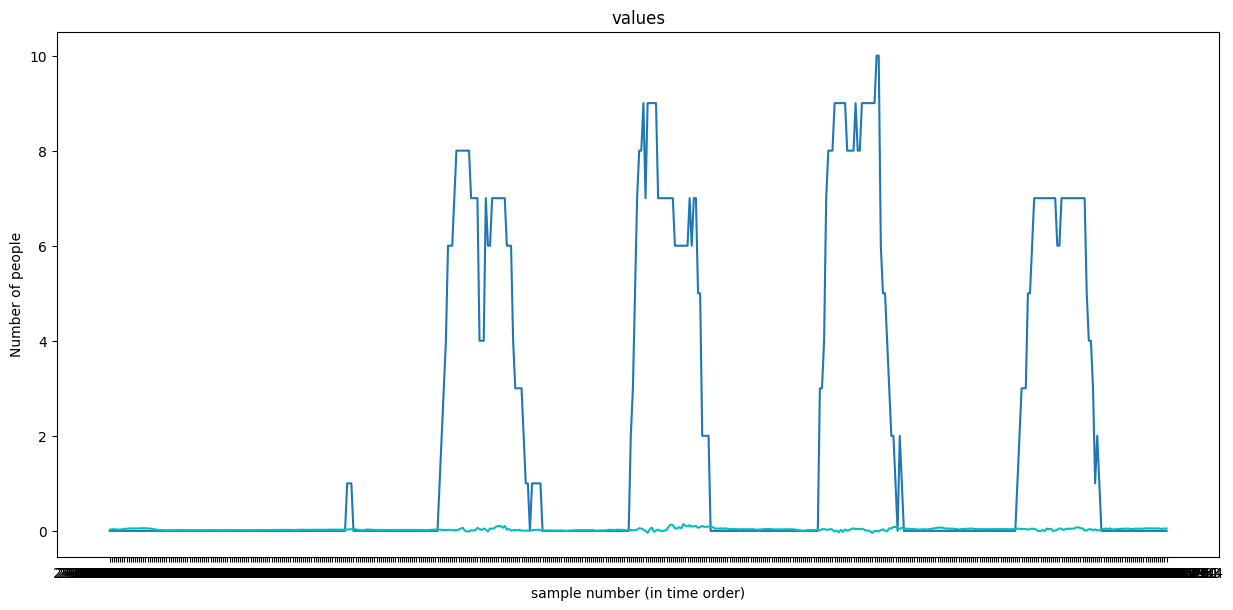

In [131]:
#plot 1:
plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.plot(y_valid_sequences)
plt.plot(predictions3,color='c')
plt.title('values')
plt.xlabel('sample number (in time order)')
plt.ylabel('Number of people')
"real values"
"predicted values"
plt.show()

In [129]:
pred_map_inco_context = map_values_to_integers(predictions3[:][0])
margin = 1.0
accuracy = regression_accuracy(y_valid_sequences, pred_map_inco_context, margin)
print(f'Regression Accuracy within ±{margin}: {accuracy:.2f}%')

Regression Accuracy within ±1.0: 69.84%


In [132]:
# Save the entire model to a keras file
model3.save('1DCNN_reg_seq_floating_windows.keras')